In [1]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers as tfkl
from tensorflow import keras as tfk
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [102]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

## Load dataset

In [73]:
dataset_dir = "C:\\Users\\franc\\Desktop\\complex\\images\\"

batch_size = 32
img_height = 48
img_width = 48


train_ds,val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    labels = 'inferred',
    image_size=(img_height, img_width),
    batch_size=32,
    shuffle=True,
    seed=123,
    validation_split = 0.2,
    subset = 'both',
    label_mode='categorical',
    color_mode='rgb',

)


Found 14488 files belonging to 3 classes.
Using 11591 files for training.
Using 2897 files for validation.


In [74]:
class_names = train_ds.class_names
class_names

['left', 'right', 'straight']

In [86]:
def rescale(image, label):
    image = tf.cast(image, tf.float32) / 255.0  # Rescale to [0, 1]
    return image, label

# Apply the rescaling function to the datasets
train_ds = train_ds.map(rescale)
val_ds = val_ds.map(rescale)

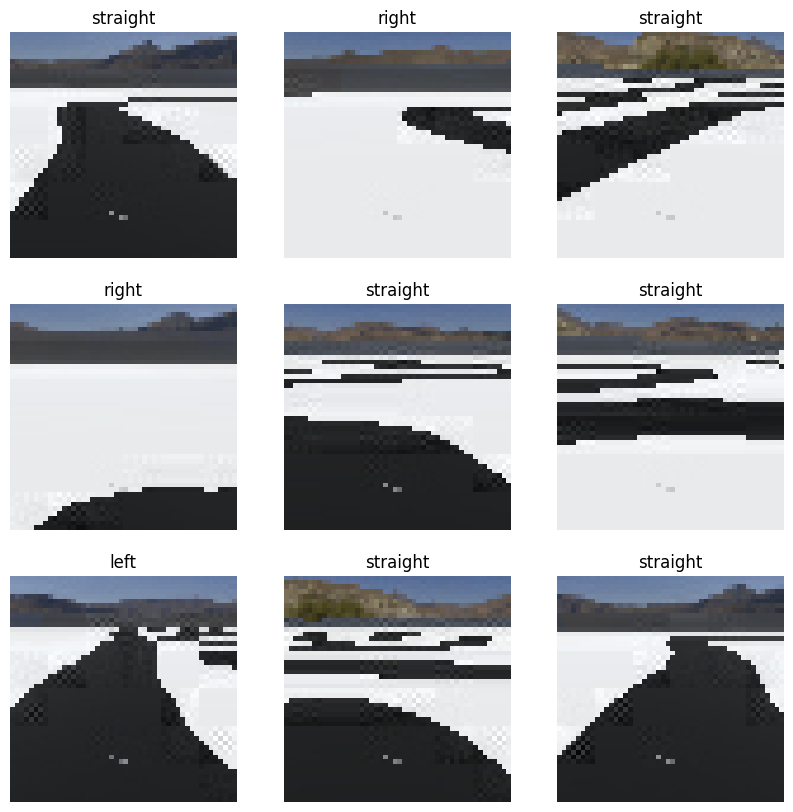

In [88]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
# un batch di 32 immagini con 32 label diverse

for images, labels in train_ds.take(2):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy())
    plt.title(class_names[tf.argmax(labels[i]).numpy()])
    plt.axis("off")
    



In [89]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 48, 48, 3)
(32, 3)


In [90]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Build the net

In [91]:
num_classes = 3

def build_LeNet(input_shape, output_shape, seed=123):
    tf.random.set_seed(seed)

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    conv1 = tfkl.Conv2D(
        filters=6,
        kernel_size=(5,5),
        padding='same',
        activation='tanh',
        name='conv1'
    )(input_layer)

    pool1 = tfkl.MaxPooling2D(
        pool_size=(2,2),
        name='mp1'
    )(conv1)

    conv2 = tfkl.Conv2D(
        filters=16,
        kernel_size=(5,5),
        padding='valid',
        activation='tanh',
        name='conv2'
    )(pool1)

    pool2 = tfkl.MaxPooling2D(
        pool_size =(2,2),
        name='mp2'
    )(conv2)

    flattening_layer=tfkl.Flatten(
        name='flatten'
    )(pool2)

    classifier_layer=tfkl.Dense(
        units=120,
        activation='tanh',
        name='dense1'
    )(flattening_layer)

    classifier_layer = tfkl.Dense(
        units=84,
        activation='tanh',
        name='dense2'
    )(classifier_layer)

    output_layer = tfkl.Dense(
        units=output_shape,
        activation='softmax',
        name='Output'
    )(classifier_layer)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='LeNet')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])

    # Return the model
    return model

In [92]:
model = build_LeNet((48,48,3), 3)
model.summary()

Model: "LeNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 48, 48, 6)      │           456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mp1 (MaxPooling2D)              │ (None, 24, 24, 6)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 20, 20, 16)     │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mp2 (MaxPooling2D)              │ (None, 10, 10, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 120)            │       192,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense2 (Dense)                  │ (None, 84)             │        10,164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 3)              │           255 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,411 (802.39 KB)

 Trainable params: 205,411 (802.39 KB)

 Non-trainable params: 0 (0.00 B)

In [93]:
early_stopping = tfk.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, mode='max', restore_best_weights=True)

history =model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=200,
  batch_size=batch_size,
  callbacks=[early_stopping]
).history

model.save('robot_net.keras')

Epoch 1/200


363/363 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.8256 - loss: 0.5056 - val_accuracy: 0.8326 - val_loss: 0.4265
Epoch 2/200
363/363 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.8413 - loss: 0.4024 - val_accuracy: 0.8412 - val_loss: 0.3990
Epoch 3/200
363/363 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.8576 - loss: 0.3584 - val_accuracy: 0.8512 - val_loss: 0.3777
Epoch 4/200
363/363 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.8729 - loss: 0.3218 - val_accuracy: 0.8561 - val_loss: 0.3658
Epoch 5/200
363/363 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.8842 - loss: 0.2887 - val_accuracy: 0.8633 - val_loss: 0.3608
Epoch 6/200
363/363 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9011 - loss: 0.2583 - val_accuracy: 0.8637 - val_loss: 0.3641
Epoch 7/200
363/363 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9139 - loss: 0.2265 - val_accuracy: 0.8643 - val_loss: 0.3775
Epoch 8/200
363/363 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9248 - loss: 0.2031 - val_accuracy:

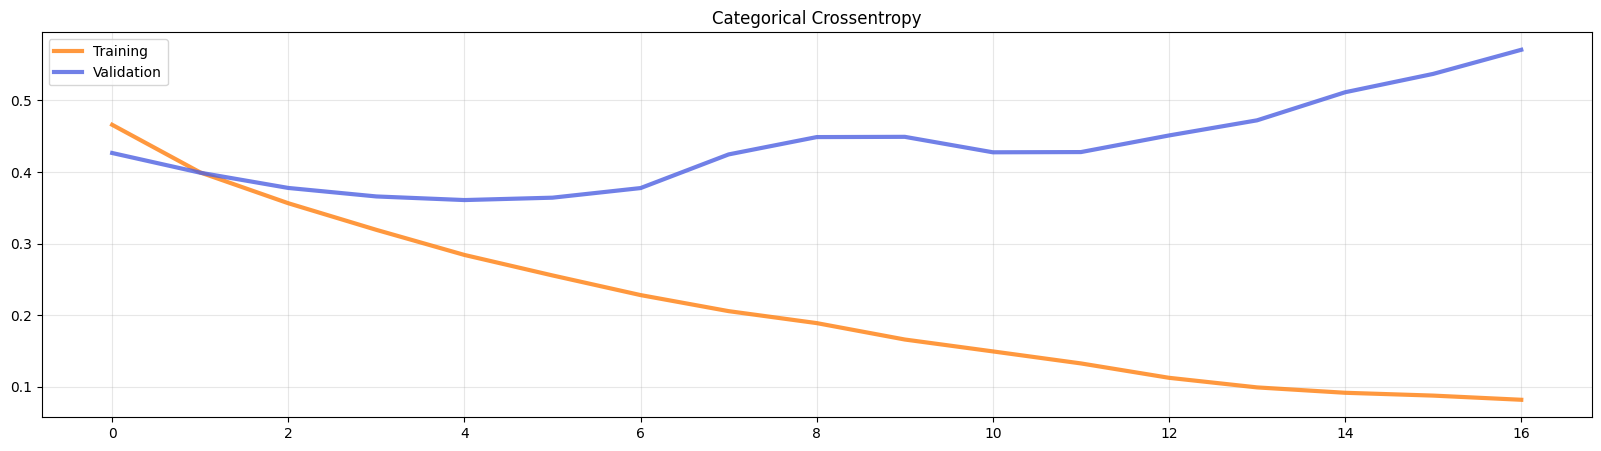

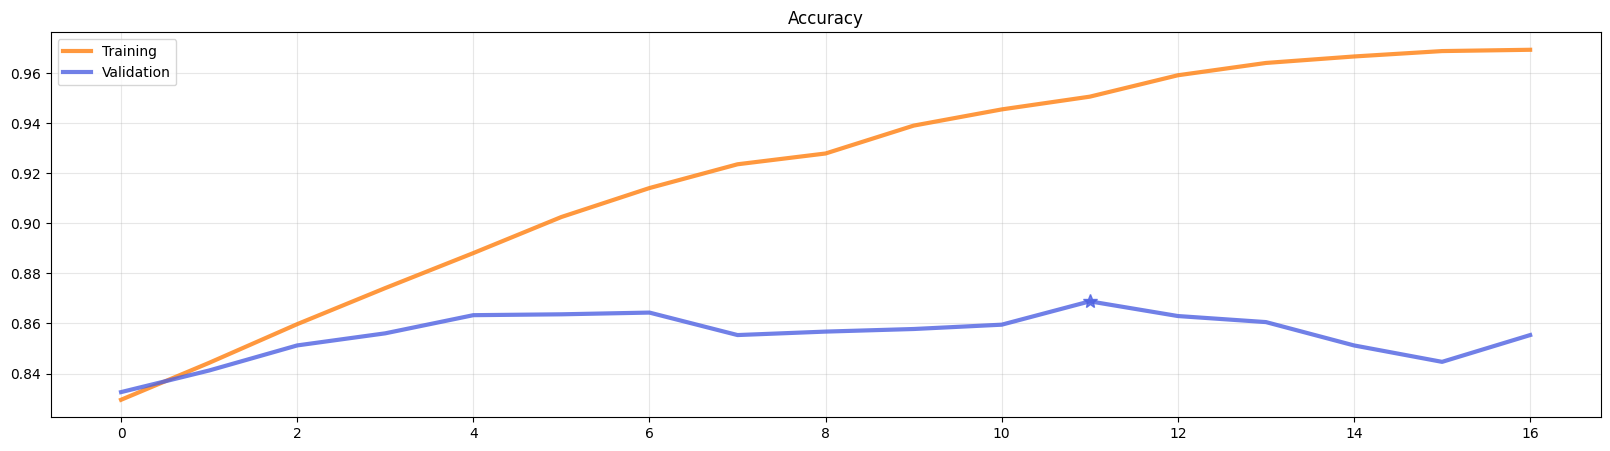

In [94]:
# Find the epoch with the highest validation accuracy
best_epoch = np.argmax(history['val_accuracy'])

# Plot training and validation performance metrics
plt.figure(figsize=(20, 5))

# Plot training and validation loss
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_loss'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=0.3)

plt.figure(figsize=(20, 5))

# Plot training and validation accuracy, highlighting the best epoch
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.plot(best_epoch, history['val_accuracy'][best_epoch], marker='*', alpha=0.8, markersize=10, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=0.3)

plt.show()

In [95]:
model = tfk.models.load_model('robot_net.keras')

In [96]:
for images,labels in val_ds.take(1):
    num_images = 30
    first_conv = tfk.Sequential(model.layers[:4])
    first_activations = first_conv(images[0:num_images])



In [97]:
print(np.argmax(labels[0]))

2


In [98]:
images[0]

<tf.Tensor: shape=(48, 48, 3), dtype=float32, numpy=
array([[[0.39607844, 0.48235294, 0.627451  ],
        [0.39215687, 0.47843137, 0.6313726 ],
        [0.39607844, 0.48235294, 0.63529414],
        ...,
        [0.46666667, 0.54509807, 0.68235296],
        [0.4627451 , 0.5411765 , 0.6784314 ],
        [0.47058824, 0.54901963, 0.6784314 ]],

       [[0.4       , 0.49019608, 0.62352943],
        [0.40392157, 0.49019608, 0.63529414],
        [0.4       , 0.4862745 , 0.6313726 ],
        ...,
        [0.45490196, 0.5137255 , 0.6431373 ],
        [0.38431373, 0.43137255, 0.5176471 ],
        [0.31764707, 0.30980393, 0.36078432]],

       [[0.41960785, 0.49803922, 0.627451  ],
        [0.4117647 , 0.4862745 , 0.6156863 ],
        [0.41960785, 0.49803922, 0.63529414],
        ...,
        [0.22745098, 0.23921569, 0.29803923],
        [0.22745098, 0.25490198, 0.29411766],
        [0.19607843, 0.20784314, 0.27450982]],

       ...,

       [[0.12941177, 0.13333334, 0.14117648],
        [0.1294

Input image


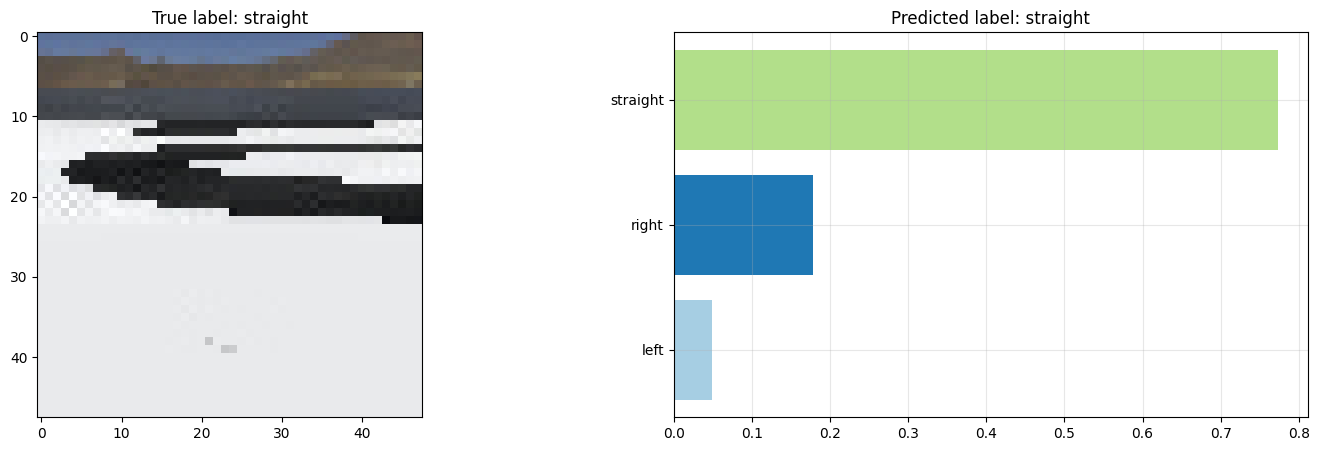

Second convolutional activations


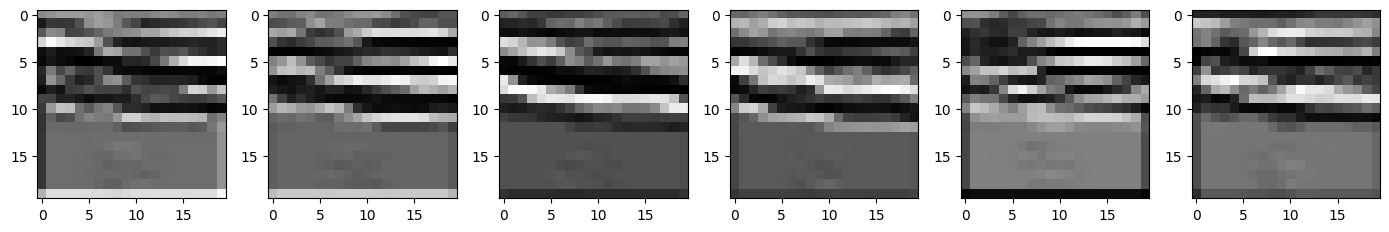

In [101]:
# Choose a random image for visualization
image = np.random.randint(0, num_images)

# Display the input image, true label, and predicted label
print('Input image')
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 5)
ax1.imshow(images[image])
ax1.set_title('True label: ' + class_names[np.argmax(labels[image])])
prediction = model.predict(np.expand_dims(images[image], axis=0), verbose=0)
ax2.barh(class_names, np.squeeze(prediction, axis=0), color=plt.get_cmap('Paired').colors)
ax2.set_title('Predicted label: ' + class_names[np.argmax(prediction)])
ax2.grid(alpha=0.3)
plt.show()

# Display activations from the first convolutional layer
print('Second convolutional activations')
num_row = 1
num_col = 6
fig, axes = plt.subplots(num_row, num_col, figsize=(14, 12))
for i in range(num_row * num_col):
    ax = axes[i % num_col]
    ax.imshow(first_activations[image, :, :, i], cmap='gray')
plt.tight_layout()
plt.show()

## confusion matrix

In [ ]:
import numpy as np

# Get the true labels and predictions
y_true = np.concatenate([y for x, y in val_ds], axis=0)
y_pred = model.predict(val_ds)
y_pred = np.argmax(y_pred, axis=1)  # Get the index of the highest predicted value
y_true = np.argmax(y_true, axis=1)  # Convert one-hot encoded labels to single integer labels


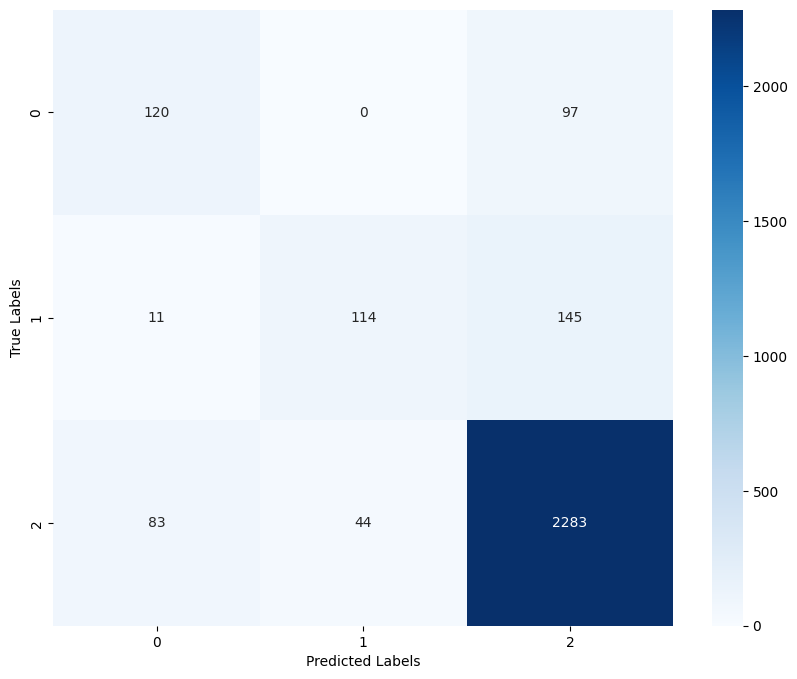

In [106]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()
